In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal

import re
from matplotlib import rc, animation
from IPython.display import HTML
import sys

In [2]:
# read in parsed data file
FILE_NAME = r'C:\Espressif\frameworks\esp-idf-v5.0\esp32-csi-tool\active_sta\Parsed_3_10.csv'
f = open(FILE_NAME)
data = pd.read_csv(f)

# store data in numpy arrays
t = data['real_timestamp'].to_numpy()
amp = data['amplitude'].to_numpy()
ph = data['phase'].to_numpy()
x = data['x'].to_numpy()
y = data['y'].to_numpy()
im = data['imaginary'].to_numpy()
real = data['real'].to_numpy()
rssi = data['rssi'].to_numpy()

In [3]:
# store all length-64 arrays of amplitude (magnitude) data into one big array
# create arrays for avg and max amplitude (magnitude) for each timestamp
rawAmp = np.zeros(amp.shape[0], dtype='object')
ampAvg = np.zeros(amp.shape[0])
ampMax = np.zeros(amp.shape[0])
for i in range(amp.shape[0]):
    current = amp[i]
    if (current == '[]'):
        rawAmp[i] = -1
        ampAvg[i] = -1
        ampMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        ampArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawAmp[i] = ampArr
        ampAvg[i] = np.average(ampArr)
        ampMax[i] = np.max(ampArr)

# store all length-64 arrays of phase data into one big array
# create arrays for avg and max phase for each timestamp
rawPh = np.zeros(ph.shape[0], dtype='object')
phAvg = np.zeros(ph.shape[0])
phMax = np.zeros(ph.shape[0])
for i in range(ph.shape[0]):
    current = ph[i]
    if (current == '[]'):
        rawPh[i] = -1
        phAvg[i] = -1
        phMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        phArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawPh[i] = phArr
        phAvg[i] = np.average(phArr)
        phMax[i] = np.max(phArr)

In [4]:
# store all length-64 arrays of real components of the data into one big array
# create arrays for avg and max real component for each timestamp
rawReal = np.zeros(real.shape[0], dtype='object')
realAvg = np.zeros(real.shape[0])
realMax = np.zeros(real.shape[0])
for i in range(real.shape[0]):
    current = real[i]
    if (current == '[]'):
        rawReal[i] = -1
        realAvg[i] = -1
        realMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        realArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawReal[i] = realArr
        realAvg[i] = np.average(realArr)
        realMax[i] = np.max(realArr)
        
# store all length-64 arrays of imaginary components of the data into one big array
# create arrays for avg and max imaginary component for each timestamp
rawIm = np.zeros(im.shape[0], dtype='object')
imAvg = np.zeros(im.shape[0])
imMax = np.zeros(im.shape[0])
for i in range(im.shape[0]):
    current = im[i]
    if (current == '[]'):
        rawIm[i] = -1
        imAvg[i] = -1
        imMax[i] = -1 
    else:
        current = current[1:]
        current = current[:-1]
        imArr = np.array([float(x) for x in current.split(", ") if x != ''])
        rawIm[i] = imArr
        imAvg[i] = np.average(imArr)
        imMax[i] = np.max(imArr)

In [5]:
# create array of distance values (distance between car and router)

router_x = 1140
router_y = 675

dist = np.zeros(x.shape[0])
for i in range(x.shape[0]):
    dist[i] = math.sqrt((x[i]**2) + y[i]**2)

In [6]:
# create RGB values for each x/y position based on the rssi for that timestamp 
# cyan = no data taken at this position
# green = best
# yellow = good
# orange = mid
# red = worst

R = np.zeros(rssi.shape[0])
G = np.zeros(rssi.shape[0])
B = np.zeros(rssi.shape[0])

# create RGB values
for i in range(rssi.shape[0]):
    if (ampAvg[i] == -1):
        R[i] = 0
        G[i] = 255
        B[i] = 255
    elif (rssi[i] >= -50):
        R[i] = 0
        G[i] = 255
        B[i] = 0
    elif (rssi[i] >= -60):
        R[i] = 255
        G[i] = 255
        B[i] = 0
    elif (rssi[i] >= -70):
        R[i] = 255
        G[i] = 255*0.75
        B[i] = 0
    else:
        R[i] = 255
        G[i] = 0
        B[i] = 0

In [7]:
# borrowed code for reading a pgm file into numpy array
np.set_printoptions(threshold=sys.maxsize)

# https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
    
    
  

In [8]:
# read in basement map file
pic=read_pgm(r'C:\Users\littl\Downloads\small_basement.pgm')
pic2=np.copy(pic)
a=np.array(3)
pic2 = np.dstack([pic2, pic2, pic2])

In [9]:
# scale x/y values to fit basement map
scale=0.01999999999
scale=(1.0/float(scale))
x1=x*scale
y1=np.absolute(y*scale)

In [10]:
# create dots on basement map using RGB values and x/y coords
for i in range(ampAvg.shape[0]):
    pic2[1236-int(y1[i])-5:1236-int(y1[i])+5,int(x1[i])-5:int(x1[i])+5:,:]= [R[i], G[i], B[i]]

# location of router (magenta)
pic2[675-5:675+5, 1140-5:1140+5] = [255, 0, 255]

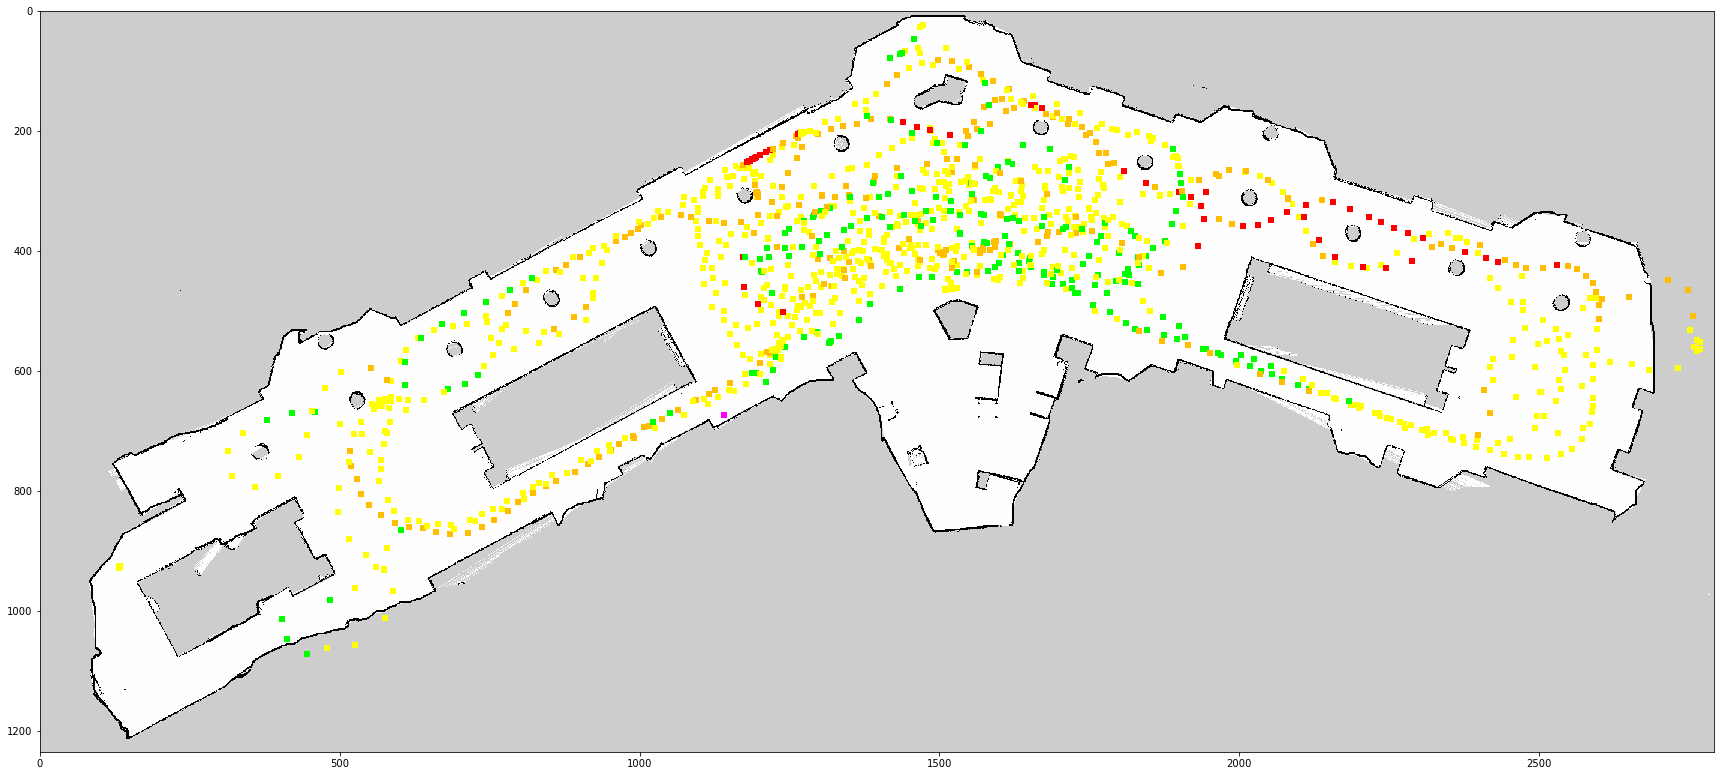

In [11]:
# plot color-coded map
plt.subplots(1, figsize=(30, 20))
plt.imshow(pic2, interpolation='nearest' )
plt.show()

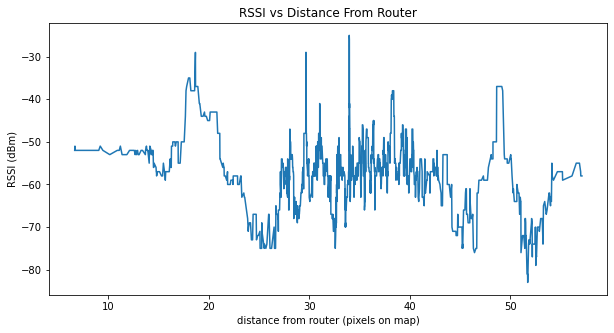

In [12]:
# plot rssi vs distance
fig = plt.figure(figsize = (10, 5))
plt.plot(np.sort(dist), rssi)
plt.xlabel('distance from router (pixels on map)')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI vs Distance From Router')
plt.show()

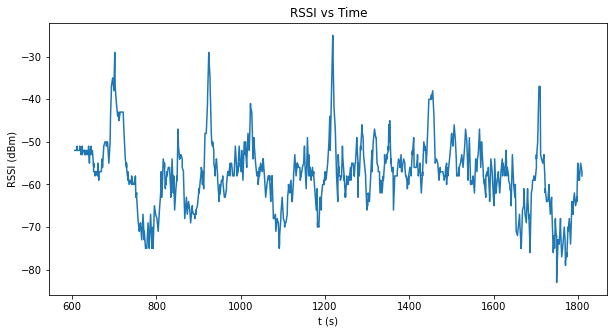

In [38]:
# plot rssi vs time
fig = plt.figure(figsize = (10, 5))
plt.plot(t, rssi)
plt.xlabel('t (s)')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI vs Time')
plt.show()

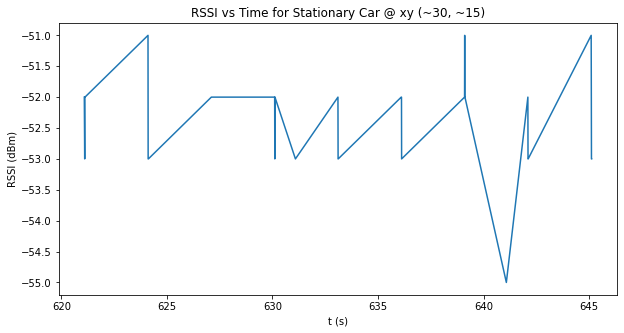

In [14]:
# plot rssi vs time for another period in which the car is barely moving
fig = plt.figure(figsize = (10, 5))
plt.plot(t[19:53], rssi[19:53])
plt.xlabel('t (s)')
plt.ylabel('RSSI (dBm)')
plt.title('RSSI vs Time for Stationary Car @ xy (~30, ~15)')
plt.show()

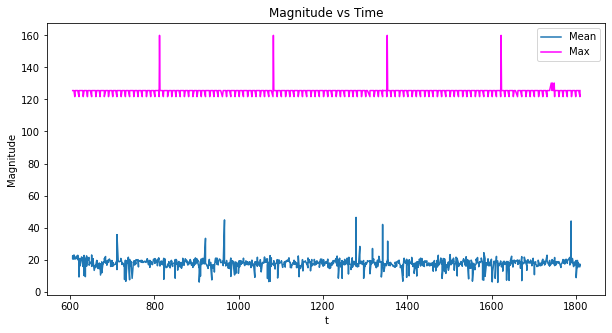

In [15]:
# plot the entirety of avg and max amplitude (magnitude) vs time
fig = plt.figure(figsize = (10, 5))
plt.plot(t, ampAvg, label='Mean')
plt.plot(t, ampMax, label='Max', color='magenta')
plt.xlabel('t')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Magnitude vs Time')
plt.show()

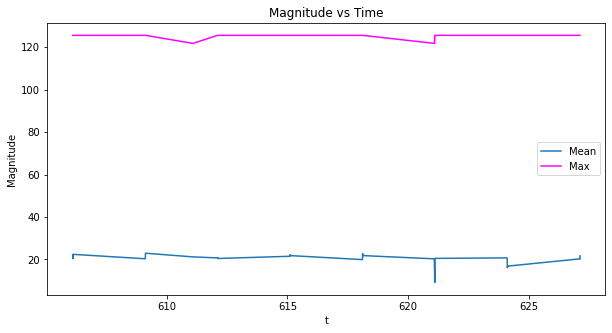

In [16]:
# plot the first 30 values of avg and max amplitude (magnitude) vs time
# just to zoom in on part of the data-- can change the indexing
# to look closer at whatever section 
fig = plt.figure(figsize = (10, 5))
plt.plot(t[:30], ampAvg[:30], label='Mean')
plt.plot(t[:30], ampMax[:30], label='Max', color='magenta')
plt.xlabel('t')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Magnitude vs Time')
plt.show()

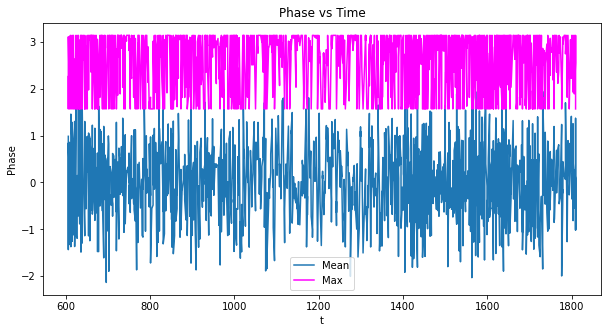

In [17]:
# plot the entirety of avg and max phase vs time
fig1 = plt.figure(figsize = (10, 5))
plt.plot(t, phAvg, label='Mean')
plt.plot(t, phMax, label='Max', color='magenta')
plt.xlabel('t')
plt.ylabel('Phase')
plt.legend()
plt.title('Phase vs Time')
plt.show()

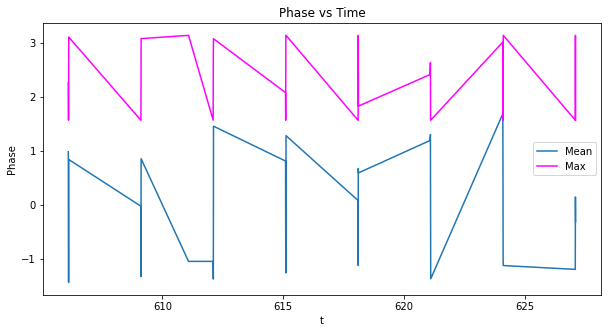

In [18]:
# plot the first 30 values of avg and max phase vs time
# just to zoom in on part of the data-- can change the indexing
# to look closer at whatever section 
fig1 = plt.figure(figsize = (10, 5))
plt.plot(t[:30], phAvg[:30], label='Mean')
plt.plot(t[:30], phMax[:30], label='Max', color='magenta')
plt.xlabel('t')
plt.ylabel('Phase')
plt.legend()
plt.title('Phase vs Time')
plt.show()

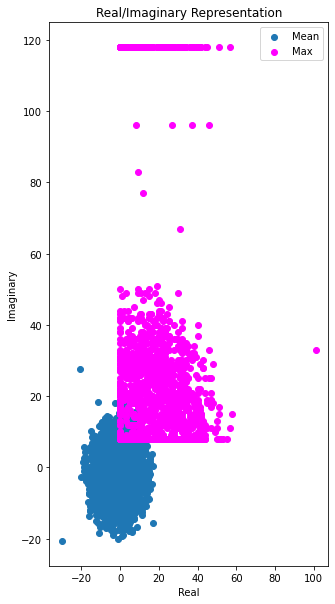

In [19]:
# plot the entirety of avg and max imaginary vs real
fig1 = plt.figure(figsize = (5, 10))
plt.scatter(realAvg, imAvg, label='Mean')
plt.scatter(realMax, imMax, label='Max', color='magenta')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.title('Real/Imaginary Representation')
plt.show()

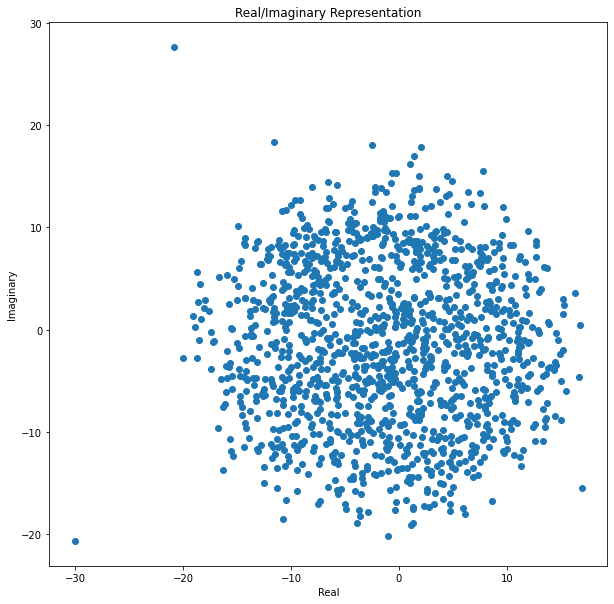

In [20]:
# plot the entirety of avg imaginary vs real
fig1 = plt.figure(figsize = (10, 10))
plt.scatter(realAvg, imAvg)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

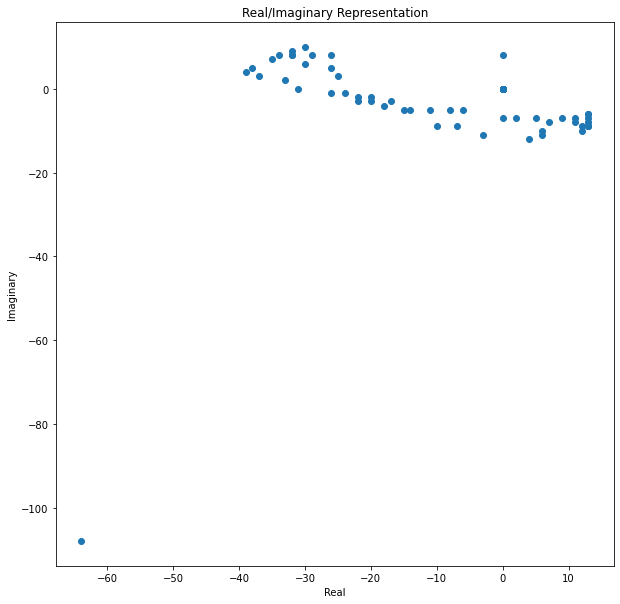

In [21]:
# plot imaginary vs real for one random timestamp
fig1 = plt.figure(figsize = (10, 10))
plt.scatter(rawReal[100], rawIm[100])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

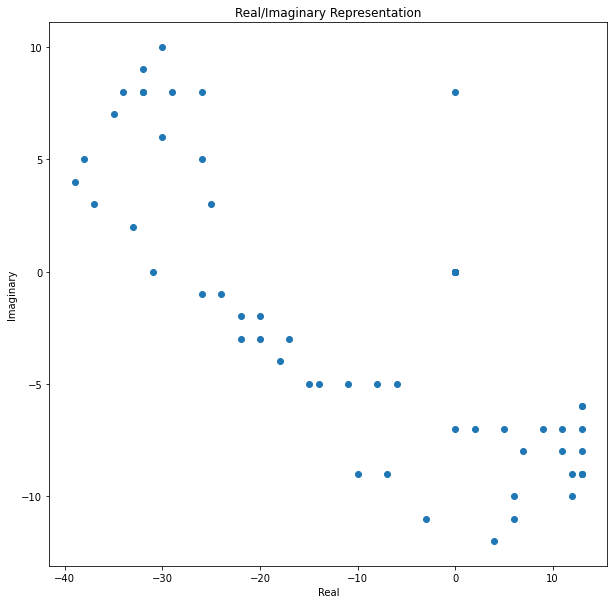

In [22]:
# plot imaginary vs real for one random timestamp, without the outlier
fig1 = plt.figure(figsize = (10, 10))
plt.scatter(rawReal[100][1:], rawIm[100][1:])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

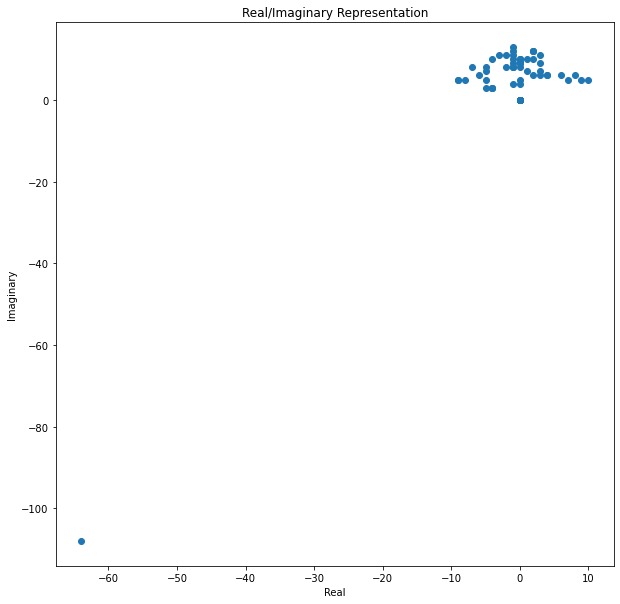

In [23]:
# plot imaginary vs real for another random timestamp
fig1 = plt.figure(figsize = (10, 10))
plt.scatter(rawReal[20], rawIm[20])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

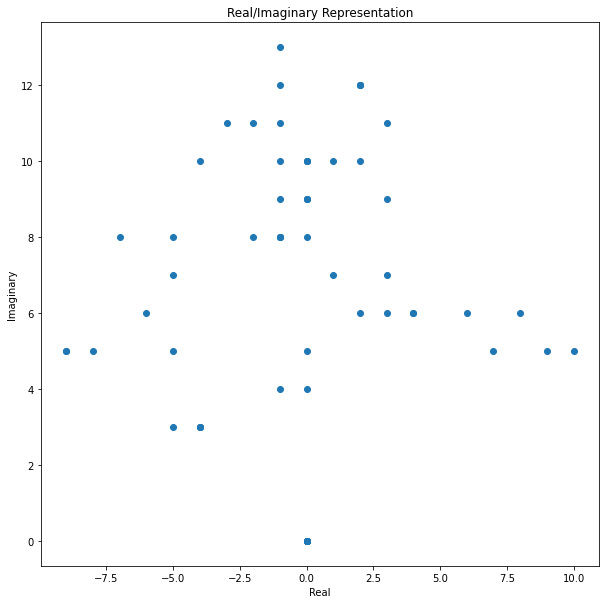

In [24]:
# plot imaginary vs real for another random timestamp, without the outlier
fig1 = plt.figure(figsize = (10, 10))
plt.scatter(rawReal[20][1:], rawIm[20][1:])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

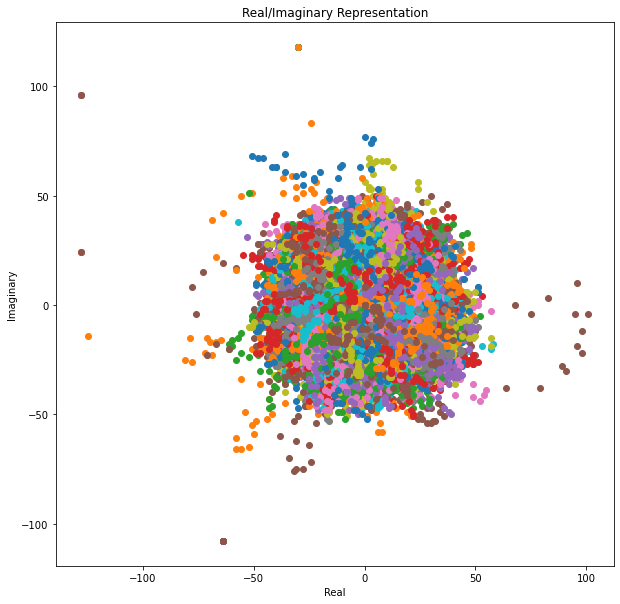

In [25]:
# plot all values of imaginary vs real for all timestamps
fig1 = plt.figure(figsize = (10, 10))
for i in range(rawReal.shape[0]):
    plt.scatter(rawReal[i], rawIm[i])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

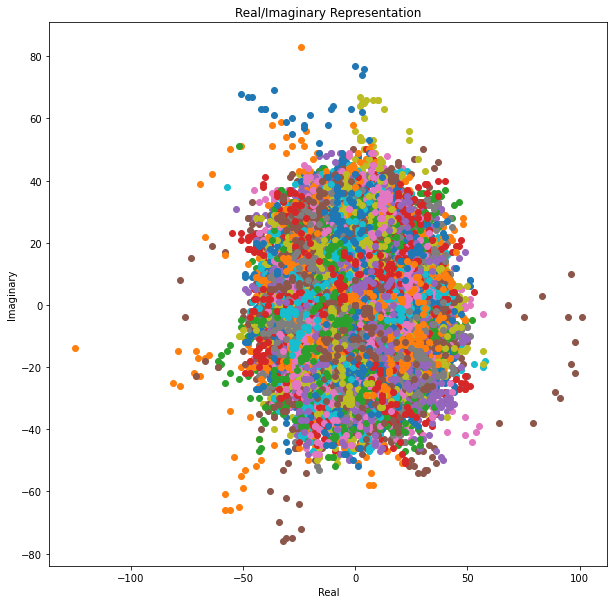

In [26]:
# plot all values and imaginary vs real for all timestamps, without the outlier
fig1 = plt.figure(figsize = (10, 10))
for i in range(rawReal.shape[0]):
    plt.scatter(rawReal[i][1:], rawIm[i][1:])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Real/Imaginary Representation')
plt.show()

In [27]:
print(rawReal[100])
print(rawIm[100])

[-64.   0. -33. -31. -26. -22. -20. -18. -14. -11.  -8.  -6.   0.   2.
   5.   7.   9.  11.  12.  13.  12.  13.  13.  13.  13.  13.  13.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  11.   6.   6.   4.
  -3.  -7. -10. -15. -17. -20. -22. -24. -25. -26. -26. -30. -29. -30.
 -32. -32. -32. -35. -34. -38. -39. -37.]
[-108.    8.    2.    0.   -1.   -2.   -3.   -4.   -5.   -5.   -5.   -5.
   -7.   -7.   -7.   -8.   -7.   -7.   -9.   -9.  -10.   -9.   -9.   -8.
   -7.   -6.   -6.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.   -8.  -10.  -11.  -12.  -11.   -9.   -9.   -5.   -3.   -2.
   -3.   -1.    3.    5.    8.    6.    8.   10.    8.    9.    8.    7.
    8.    5.    4.    3.]


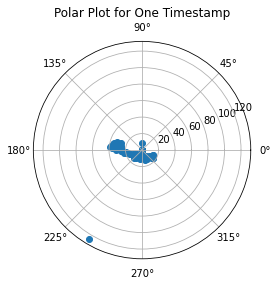

In [28]:
# Polar plot for one random timestamp
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title("Polar Plot for One Timestamp")
c = ax.scatter(rawPh[100], rawAmp[100])
plt.show()

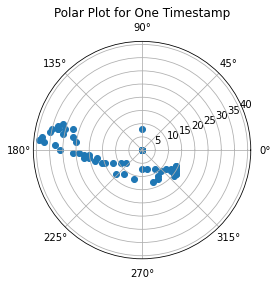

In [29]:
# Polar plot for one random timestamp, without the outlier
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title("Polar Plot for One Timestamp")
c = ax.scatter(rawPh[100][1:], rawAmp[100][1:])
plt.show()

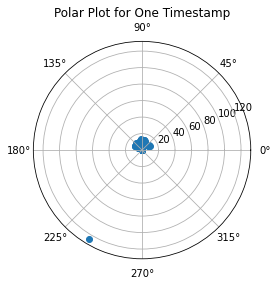

In [30]:
# Polar plot for another random timestamp
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title("Polar Plot for One Timestamp")
c = ax.scatter(rawPh[20], rawAmp[20])
plt.show()

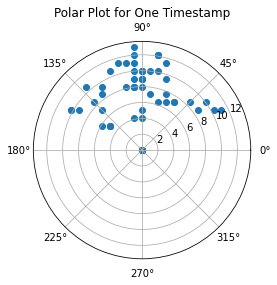

In [31]:
# Polar plot for another random timestamp, without the outlier
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title("Polar Plot for One Timestamp")
c = ax.scatter(rawPh[20][1:], rawAmp[20][1:])
plt.show()

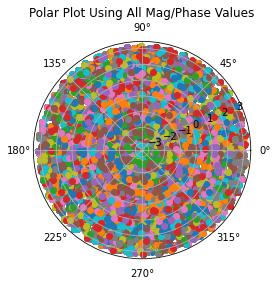

In [34]:
# Polar plot using all mag/phase values for all timestamps
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title("Polar Plot Using All Mag/Phase Values")
for i in range(rawAmp.shape[0]):
    c = ax.scatter(rawAmp[i], rawPh[i])
plt.show()

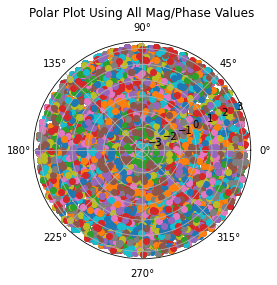

In [35]:
# Polar plot using all mag/phase values for all timestamps, without outliers
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_title("Polar Plot Using All Mag/Phase Values")
for i in range(rawAmp.shape[0]):
    c = ax.scatter(rawAmp[i][1:], rawPh[i][1:])
plt.show()

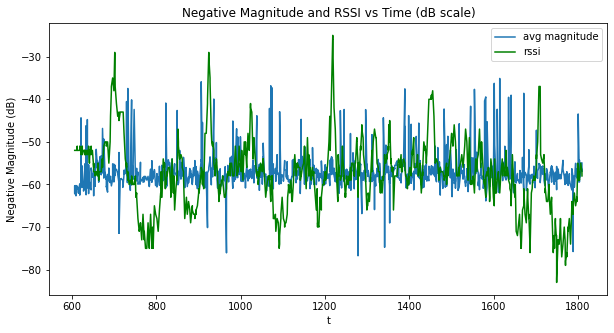

In [37]:
# plot the entirety of negative avg magnitude in dB and rssi vs time
fig = plt.figure(figsize = (10, 5))
plt.plot(t, -20*np.log(ampAvg), label='avg magnitude')
plt.plot(t, rssi, label='rssi', color='green')
plt.xlabel('t')
plt.ylabel('Negative Magnitude (dB)')
plt.legend()
plt.title('Negative Magnitude and RSSI vs Time (dB scale)')
plt.show()